# Denoising with the deep decoder

The code below demonstrates the denoising performance on an example image.

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


## Load image

In [3]:
path = './test_data/'
img_name = "astronaut"
#img_name = "phantom256"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

## Generate noisy image

In [4]:
#sig = 0.35
#sigma = sig/255.
sig = 30
sigma = sig/255.
    
noise_same = False
if noise_same: # add the same noise in each channel
    noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
    noise = np.array( [noise]*img_np.shape[0] )
else: # add independent noise in each channel
    noise = np.random.normal(scale=sigma, size=img_np.shape)

img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
img_noisy_var = np_to_var(img_noisy_np).type(dtype)

img_only_noisy_np = np.clip(noise, 0, 1)
img_only_noisy_var = np_to_var(img_only_noisy_np).type(dtype)

output_depth = img_np.shape[0] 
print("Image size: ", img_np.shape)

Image size:  (3, 512, 512)


## Denoise noisy image

In [5]:
num_channels = [128]*5
net = decodernw(output_depth,num_channels_up=num_channels).type(dtype)

numit = 10000
rn = 0.015

print(img_noisy_var.data.shape, img_clean_var.data.shape,  img_only_noisy_var.data.shape)

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var)

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])
shape:  [1, 128, 16, 16]
optimize with adam 0.01


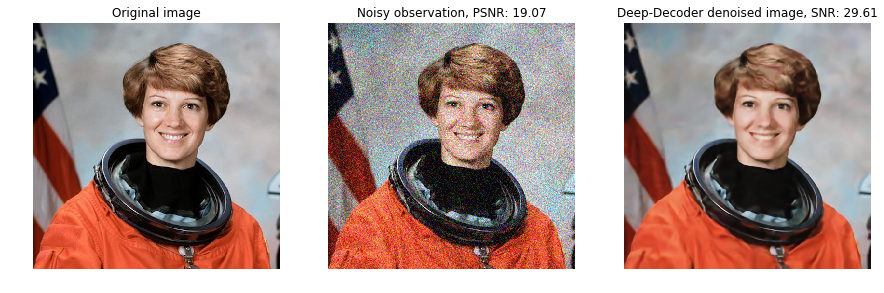

In [6]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1,img_np) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
myimgshow(ax2,img_noisy_np)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
ax2.axis('off')

out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
ax3 = fig.add_subplot(133)
myimgshow(ax3,out_img_np)
ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
ax3.axis('off')    

plt.show()